# Import libraries

In [1]:
import yfinance as yf
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import math as m

from sklearn.preprocessing import StandardScaler
# from tensorboard_logger import configure

import copy
import sys
import os

import prep_data
import train

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, TensorDataset

from models.transformer import Transformer
from models.rnn import RNN
from models.autoformer import Autoformer

In [2]:
if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)

print(dev)

cuda:0


# Load data from `yfinance`

In [3]:
X, y, scaler = prep_data.log_returns(seq_len=128, horizon=1)
X, y

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  2143.669922  2148.709961  2122.989990  2141.770020  2141.219482   
2000-01-04  2151.550049  2158.209961  2130.679932  2153.179932  2152.626465   
2000-01-05  2113.379883  2113.379883  2070.139893  2074.750000  2074.216553   
2000-01-06  2079.050049  2082.810059  2066.879883  2079.110107  2078.575684   
2000-01-07  2079.320068  2094.290039  2077.649902  2094.290039  2093.751709   

            Volume  
Date                
2000-01-03       0  
2000-01-04       0  
2000-01-05       0  
2000-01-06       0  
2000-01-07       0  


(tensor([[[-0.0145],
          [-0.0145],
          [-0.0145],
          ...,
          [-0.0145],
          [ 0.0744],
          [ 0.5592]],
 
         [[-0.0145],
          [-0.0145],
          [-0.0145],
          ...,
          [-0.0145],
          [-0.0145],
          [ 0.0744]],
 
         [[-0.0145],
          [-0.0145],
          [-0.0145],
          ...,
          [-0.0145],
          [-0.0145],
          [-0.0145]],
 
         ...,
 
         [[-0.0145],
          [-0.0145],
          [-0.3328],
          ...,
          [-0.0145],
          [-0.0145],
          [-0.0145]],
 
         [[-0.0145],
          [-0.0145],
          [-0.0145],
          ...,
          [-1.6898],
          [-0.0145],
          [-0.0145]],
 
         [[-0.0145],
          [-0.0145],
          [-0.0145],
          ...,
          [ 1.1696],
          [-1.6898],
          [-0.0145]]]),
 tensor([[[-0.0145]],
 
         [[-0.0145]],
 
         [[-1.4659]],
 
         ...,
 
         [[-0.0145]],
 
        

In [4]:
X_train, X_test = prep_data.train_test_split(X)
y_train, y_test = prep_data.train_test_split(y)

In [9]:
%%time
model_rnn, loss_rnn, train_pred_rnn, test_pred_rnn = train.train(
                                                        model=RNN(dropout=0.2), 
                                                        X_train=X_train, 
                                                        y_train=y_train, 
                                                        X_test=X_test, 
                                                        y_test=y_test, 
                                                        max_epoch=10,
                                                        batch_size=32,
                                                        loss=nn.MSELoss(),
                                                        optimizer=optim.Adam,
                                                        lr=1e-4,
                                                        device=dev
                                                    )

Epoch 0 | train loss 0.6269250952679178 | test_loss 0.5944202542304993
Epoch 1 | train loss 0.6248029625934103 | test_loss 0.5942913889884949
Epoch 2 | train loss 0.6261852927829908 | test_loss 0.5941330790519714
Epoch 3 | train loss 0.6245577853658925 | test_loss 0.5937440991401672
Epoch 4 | train loss 0.6260536027991254 | test_loss 0.5936562418937683
Epoch 5 | train loss 0.6238777326500934 | test_loss 0.5933871865272522
Epoch 6 | train loss 0.622827032338018 | test_loss 0.5935478806495667
Epoch 7 | train loss 0.6248156091441279 | test_loss 0.5933265089988708
Epoch 8 | train loss 0.6247736889383068 | test_loss 0.5933454036712646
Epoch 9 | train loss 0.623428552047066 | test_loss 0.593553364276886
<class 'numpy.float64'> <class 'numpy.ndarray'>
CPU times: user 3.33 s, sys: 1.14 s, total: 4.47 s
Wall time: 4.96 s


In [10]:
for column in train_pred_rnn.columns:
    train_pred_rnn[column] = scaler.inverse_transform(train_pred_rnn[column].values.reshape(-1,1))

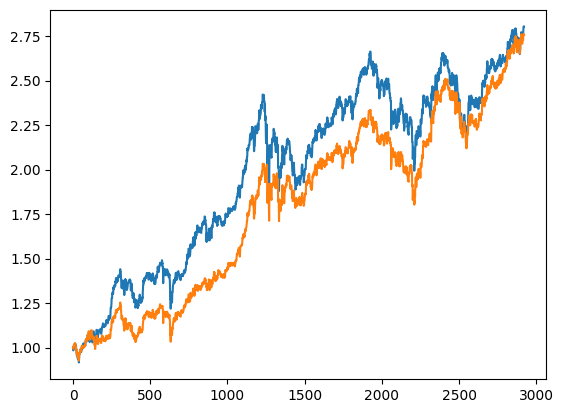

In [7]:
plt.plot(np.exp(train_pred_rnn[["y", "epoch_999"]].cumsum()))

In [10]:
for column in test_pred_rnn.columns:
    test_pred_rnn[column] = scaler.inverse_transform(test_pred_rnn[column].values.reshape(-1,1))

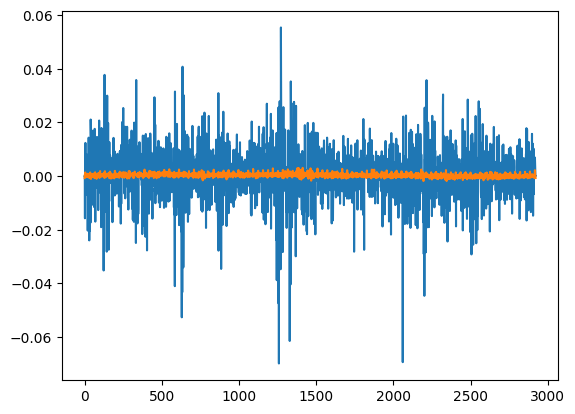

In [11]:
plt.plot(train_pred_rnn[["y", "epoch_9"]])

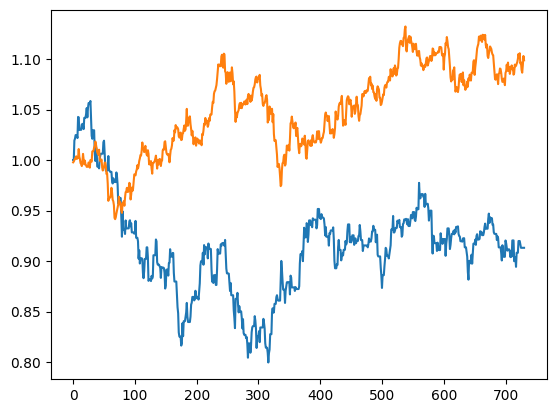

In [12]:
plt.plot(np.exp(test_pred_rnn[["y", "epoch_999"]].cumsum()))

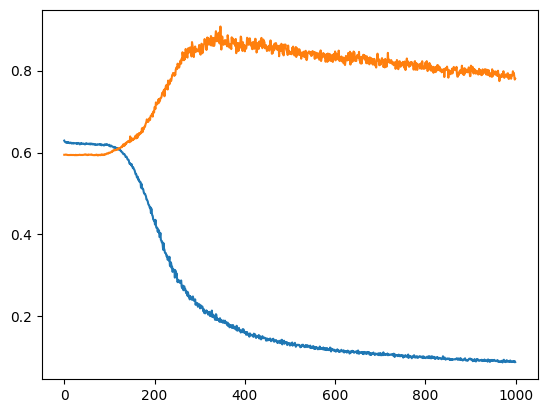

In [23]:
plt.plot(loss_rnn)

In [4]:
%%time
model_transformer, loss_transformer, train_pred_transformer, test_pred_transformer = train.train(
                                                                                        model=Transformer(dropout=0.4), 
                                                                                        seq_len=128,
                                                                                        horizon=1,
                                                                                        max_epoch=10,
                                                                                        batch_size=32,
                                                                                        loss=nn.MSELoss(),
                                                                                        optimizer=optim.Adam,
                                                                                        lr=1e-4,
                                                                                        device=dev
                                                                                    )

[*********************100%%**********************]  1 of 1 completed


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  2143.669922  2148.709961  2122.989990  2141.770020  2141.219482   
2000-01-04  2151.550049  2158.209961  2130.679932  2153.179932  2152.626465   
2000-01-05  2113.379883  2113.379883  2070.139893  2074.750000  2074.216553   
2000-01-06  2079.050049  2082.810059  2066.879883  2079.110107  2078.575684   
2000-01-07  2079.320068  2094.290039  2077.649902  2094.290039  2093.751709   

            Volume  
Date                
2000-01-03       0  
2000-01-04       0  
2000-01-05       0  
2000-01-06       0  
2000-01-07       0  
Epoch 0 | train loss 0.5139130302097487 | test_loss 0.3777265250682831
Epoch 1 | train loss 0.3318650204202403 | test_loss 0.5514440536499023
Epoch 2 | train loss 0.2950695493946905 | test_loss 0.8818422555923462
Epoch 3 | train loss 0.2509431217027747 | test_loss 1.0596660375595093
Epoch 4 | train

In [6]:
for column in train_pred_transformer.columns:
    train_pred_transformer[column] = scaler.inverse_transform(train_pred_transformer[column].values.reshape(-1,1))
for column in test_pred_transformer.columns:
    test_pred_transformer[column] = scaler.inverse_transform(test_pred_transformer[column].values.reshape(-1,1))

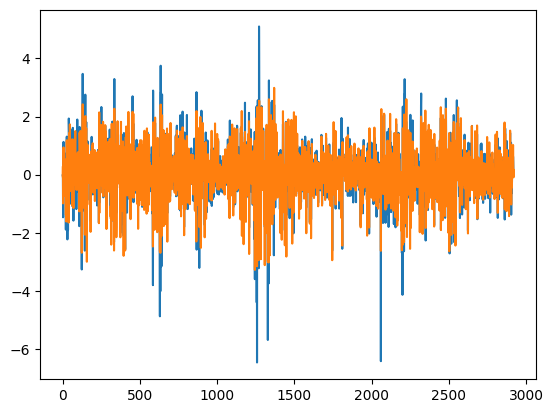

In [13]:
plt.plot(train_pred_transformer[["y", "epoch_9"]])

In [5]:
%%time
model_autoformer, loss_autoformer, train_pred_autoformer, test_pred_autoformer = train.train(
                                                                                        model=Autoformer(dropout=0.4), 
                                                                                        X_train=X_train, 
                                                                                        y_train=y_train, 
                                                                                        X_test=X_test, 
                                                                                        y_test=y_test, 
                                                                                        max_epoch=10,
                                                                                        batch_size=32,
                                                                                        loss=nn.MSELoss(),
                                                                                        optimizer=optim.Adam,
                                                                                        lr=1e-4,
                                                                                        device=dev
                                                                                    )

TypeError: AutoformerModel.forward() missing 2 required positional arguments: 'past_time_features' and 'past_observed_mask'

In [3]:
%%time
model_transformer, loss_transformer, train_pred_transformer, test_pred_transformer, train_price_transformer, test_price_transformer = train.train_cumsum(
                                                                                        model=Transformer(dropout=0.4), 
                                                                                        seq_len=128,
                                                                                        horizon=1,
                                                                                        max_epoch=10,
                                                                                        batch_size=32,
                                                                                        loss=nn.MSELoss(),
                                                                                        optimizer=optim.Adam,
                                                                                        lr=1e-4,
                                                                                        device=dev
                                                                                    )

[*********************100%%**********************]  1 of 1 completed


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  2143.669922  2148.709961  2122.989990  2141.770020  2141.219482   
2000-01-04  2151.550049  2158.209961  2130.679932  2153.179932  2152.626465   
2000-01-05  2113.379883  2113.379883  2070.139893  2074.750000  2074.216553   
2000-01-06  2079.050049  2082.810059  2066.879883  2079.110107  2078.575684   
2000-01-07  2079.320068  2094.290039  2077.649902  2094.290039  2093.751709   

            Volume  
Date                
2000-01-03       0  
2000-01-04       0  
2000-01-05       0  
2000-01-06       0  
2000-01-07       0  
<class 'torch.Tensor'>
<built-in method values of Tensor object at 0x7fe7572531a0>
<class 'torch.Tensor'>


TypeError: unsupported operand type(s) for *: 'builtin_function_or_method' and 'Tensor'

`# Prepare dataframe for `neuralforecast`

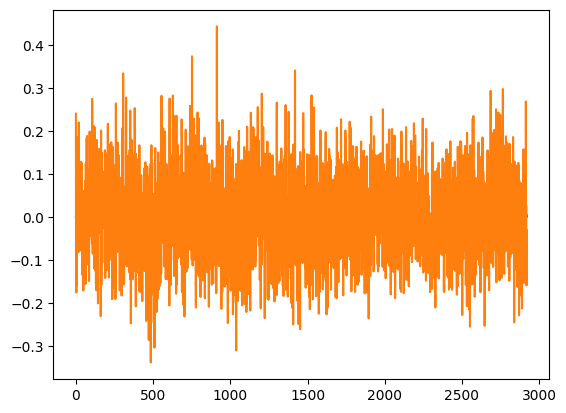

In [8]:
plt.plot(train_pred_transformer[["y", "epoch_2"]])

In [ ]:
INPUT_DIM = 128
OUTPUT_DIM = 1
BATCH = 32

In [ ]:
plt.plot(df_lst[-1]["y"])

In [ ]:
val_size = m.ceil(.2*len(raw_data.index))
test_size = m.ceil(.2*len(raw_data.index))

In [ ]:
N_LAYERS = [1,2,4]
HORIZON = [1,5,30]
LEARNING_RATE = [1e-5]
SEQ_LENGTH =  [128]
EPOCH = [1000]
N_HEAD = [2,4]    # Number of attention heads
D_MODEL =  [64,128]  # Hidden dimension of the model
BATCH_SIZE = [16,32,64]
DROPOUT = [0.1*i for i in range(5)]

In [ ]:
pred2 = nf.predict_insample()

In [ ]:
results = [nf.models[i].results.get_dataframe() for i in range(len(models))]

for model in results:
    print(model)

In [ ]:
pred2

In [ ]:
pred

In [ ]:
y_true_2 = pred2['y'].values
y_transformer_2 = pred2['VanillaTransformer'].values
y_rnn_2 = pred2['RNN'].values

n_series = len(pred2['unique_id'].unique())
y_true_2 = y_true_2.reshape(n_series, -1, horizon)
y_transformer_2 = y_transformer_2.reshape(n_series, -1, horizon)
y_rnn_2 = y_rnn_2.reshape(n_series, -1, horizon)

In [ ]:
pred2

In [ ]:
results = nf.models[0].results.trials_dataframe()

In [ ]:
hello2 = pred2.groupby(['ds'])[
    ["y",
     "AutoRNN",
     "AutoVanillaTransformer",
     "AutoAutoformer"
     ]
].mean()

for i in range(2010,2017):
  plt.figure(figsize=(15,3))
  plt.plot(hello2.loc[f"{i}-01-01":f"{i+1}-01-01":], linewidth=0.75)
  plt.legend(["True", "RNN", "Transformer", "Autoformer"])

In [ ]:
nf.save(path="/content/dataset")

In [ ]:
y_true = pred['y'].values
y_transformer = pred['VanillaTransformer'].values
y_rnn = pred['RNN'].values

n_series = len(pred['unique_id'].unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_transformer = y_transformer.reshape(n_series, -1, horizon)
y_rnn = y_rnn.reshape(n_series, -1, horizon)

In [ ]:
y_transformer.shape

In [ ]:
from neuralforecast.losses.numpy import mae, mse, mape, rmse

In [ ]:
print("Train")
print(f"Transformer: MSE: {mse(y_true_2, y_transformer_2)}, MAE: {mae(y_true_2, y_transformer_2)}, MAPE: {mape(y_true_2, y_transformer_2)}, RMSE: {rmse(y_true_2, y_transformer_2)}")
print(f"RNN: MSE: {mse(y_true_2, y_rnn_2)}, MAE: {mae(y_true_2, y_rnn_2)}, MAPE: {mape(y_true_2, y_rnn_2)}, RMSE: {rmse(y_true_2, y_rnn_2)}")
print("Test")
print(f"Transformer: MSE: {mse(y_true, y_transformer)}, MAE: {mae(y_true, y_transformer)}, MAPE: {mape(y_true, y_transformer)}, RMSE: {rmse(y_true, y_transformer)}")
print(f"RNN: MSE: {mse(y_true, y_rnn)}, MAE: {mae(y_true, y_rnn)}, MAPE: {mape(y_true, y_rnn)}, RMSE: {rmse(y_true, y_rnn)}")

In [ ]:
hello = pred.groupby(['ds'])[['y','VanillaTransformer','VanillaTransformer1','VanillaTransformer2','VanillaTransformer3','VanillaTransformer4']].mean()
for i in range(2018,2020):
  plt.figure(figsize=(15,3))
  plt.plot(hello.loc[f"{i}-01-01":f"{i+1}-01-01":], linewidth=0.75)
  plt.legend(['True', 'Dropout 0', 'Dropout 0.1', 'Dropout 0.2', 'Dropout 0.3', 'Dropout 0.4'])

In [ ]:

series = ['PSEI']
series_idx = 3

for w_idx in enumerate([200, 300, 400]):
  plt.figure()
  plt.plot(y_true[0, w_idx,:].flatten(),label='True',color="r")
  plt.plot(y_transformer[0, w_idx,:].flatten(), label='VanillaTransformer', color="g")
  plt.plot(y_rnn[0, w_idx,:].flatten(),label='RNN', color="b")
  plt.grid()
  if idx==2:
    plt.set_xlabel('Forecast Horizon', fontsize=17)

In [ ]:
hello = pred.groupby(['cutoff'])[['y','VanillaTransformer','RNN']].mean()

In [ ]:
hello['ds'] = hello.index

In [ ]:
plt.figure(figsize = (20,4), linewidth=1)
plt.plot(hello['ds'],hello['y'], label='true')
plt.plot(hello['ds'],hello['VanillaTransformer'], label='Transformer')
plt.plot(hello['ds'],hello['RNN'], label='RNN')
plt.legend()